In [6]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import tensorflow as tf
import torch
import torchvision
import IPython.display as display

from PIL import Image
from numba import cuda

from tensorflow.keras.preprocessing import timeseries_dataset_from_array, image

from imageai.Detection.Custom import DetectionModelTrainer, CustomObjectDetection

# Load the TensorBoard notebook extension
%load_ext tensorboard
%matplotlib inline

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [2]:
torch.cuda.is_available()

True

In [4]:
!nvidia-smi

Sun Mar  5 19:57:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0 Off |                  N/A |
| N/A   41C    P8    N/A /  N/A |      0MiB /  2048MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

sys:1: ResourceWarning: unclosed socket <zmq.Socket(zmq.PUSH) at 0x1a46ab18640>
D:\ProgramData\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedWriter name=4>
  return process_handler(cmd, _system_body)
D:\ProgramData\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=5>
  return process_handler(cmd, _system_body)
D:\ProgramData\Anaconda3\lib\site-packages\IPython\utils\_process_win32.py:145: ResourceWarning: unclosed file <_io.BufferedReader name=6>
  return process_handler(cmd, _system_body)


In [5]:
tf.random.set_seed(43)

In [6]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.5)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [8]:
tf.config.set_soft_device_placement(True)

#### Load and preparing Car Object Detection Dataset for Training YOLO Object Detector

In [3]:
PATH = 'D:/Data/Study/car_object_detection/'

In [4]:
df = pd.read_csv(PATH+'train_solution_bounding_boxes.csv')

In [5]:
df.index

RangeIndex(start=0, stop=559, step=1)

In [6]:
df['image'].describe()

count                 559
unique                355
top       vid_4_26460.jpg
freq                    7
Name: image, dtype: object

In [7]:
img_info = image.load_img(PATH+'train/images/vid_4_6480.jpg')

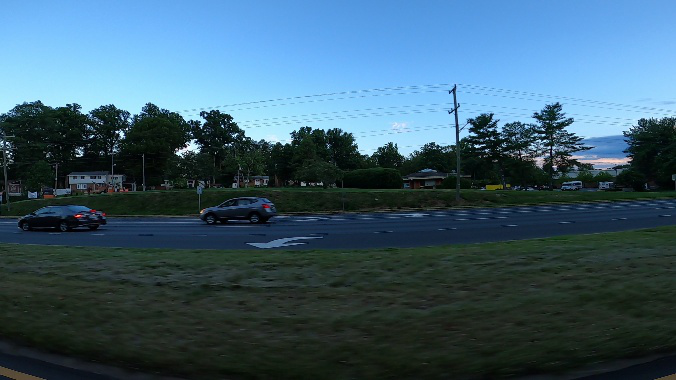

In [8]:
img_info

In [9]:
img_info.width, img_info.height

(676, 380)

In [10]:
x_k = 416/img_info.width
y_k = 416/img_info.height

In [11]:
x_k, y_k

(0.6153846153846154, 1.0947368421052632)

In [12]:
for i in df.index:
    with open(PATH+"train/annotations/" + df.iloc[i]['image'][:-4] + ".txt", 'a') as file:
        file.write(f"{0} {(df.iloc[i]['xmin'] + df.iloc[i]['xmax'])*x_k/2/416} "
                   f"{(df.iloc[i]['ymin'] + df.iloc[i]['ymax'])*y_k/2/416} " 
                   f"{(df.iloc[i]['xmax'] - df.iloc[i]['xmin'])*x_k/416} "
                   f"{(df.iloc[i]['ymax'] - df.iloc[i]['ymin'])*y_k/416}\n")

In [13]:
ann = os.listdir(PATH+'train/annotations')
img = os.listdir(PATH+'train/images')

for name_i in img:
    flag = 0
    for name_a in ann:
        if name_a[:-4]+'.jpg' == name_i:
            flag +=1
    if flag == 0:
        os.remove(PATH+'train/images/'+name_i)

In [14]:
ann = os.listdir(PATH+'train/annotations')
img = os.listdir(PATH+'train/images')
for name_a, a in zip(ann, range(round(len(ann)*0.2))):
    os.rename(PATH+'train/annotations/'+name_a, PATH+'validation/annotations/'+name_a)
    a += 1
for name_i, i in zip(img, range(round(len(img)*0.2))):
    os.rename(PATH+'train/images/'+name_i, PATH+'validation/images/'+name_i)
    i += 1

#### Custom Object Detection: Training and Inference ImageAI

In [15]:
from imageai.Detection.Custom import DetectionModelTrainer
trainer = DetectionModelTrainer()
trainer.setModelTypeAsYOLOv3()
trainer.setDataDirectory(data_directory='D:/Data/Study/car_object_detection/')

trainer.setTrainConfig(object_names_array=['car'], 
                       batch_size=2, 
                       num_experiments=50, train_from_pretrained_model='D:/Data/Study/car_object_detection/yolov3.pt')
trainer.trainModel()

Generating anchor boxes for training images...
thr=0.25: 1.0000 best possible recall, 8.79 anchors past thr
n=9, img_size=416, metric_all=0.616/0.899-mean/best, past_thr=0.626-mean: 
Pretrained YOLOv3 model loaded to initialize weights
Epoch 1/50
----------
Train: 


142it [01:24,  1.68it/s]


    box loss-> 0.09305, object loss-> 0.17454, class loss-> 0.00000
Validation:


71it [04:08,  3.49s/it]


    recall: 0.156650 precision: 0.241959 mAP@0.5: 0.084967, mAP@0.5-0.95: 0.016860

Epoch 2/50
----------
Train: 


142it [01:35,  1.49it/s]


    box loss-> 0.06704, object loss-> 0.05227, class loss-> 0.00000
Validation:


71it [03:58,  3.36s/it]


    recall: 0.416667 precision: 0.443530 mAP@0.5: 0.421857, mAP@0.5-0.95: 0.112217

Epoch 3/50
----------
Train: 


142it [01:38,  1.45it/s]


    box loss-> 0.05934, object loss-> 0.04725, class loss-> 0.00000
Validation:


71it [04:24,  3.72s/it]


    recall: 0.333333 precision: 0.507484 mAP@0.5: 0.401868, mAP@0.5-0.95: 0.085687

Epoch 4/50
----------
Train: 


142it [02:18,  1.03it/s]


    box loss-> 0.05666, object loss-> 0.04467, class loss-> 0.00000
Validation:


71it [03:09,  2.67s/it]


    recall: 0.555556 precision: 0.442485 mAP@0.5: 0.447272, mAP@0.5-0.95: 0.094419

Epoch 5/50
----------
Train: 


142it [04:27,  1.88s/it]


    box loss-> 0.05606, object loss-> 0.04474, class loss-> 0.00000
Validation:


71it [02:30,  2.13s/it]


    recall: 0.537037 precision: 0.339101 mAP@0.5: 0.357535, mAP@0.5-0.95: 0.087572

Epoch 6/50
----------
Train: 


142it [09:13,  3.90s/it]


    box loss-> 0.05126, object loss-> 0.04261, class loss-> 0.00000
Validation:


71it [02:24,  2.04s/it]


    recall: 0.527778 precision: 0.386448 mAP@0.5: 0.413952, mAP@0.5-0.95: 0.087103

Epoch 7/50
----------
Train: 


142it [04:53,  2.07s/it]


    box loss-> 0.04735, object loss-> 0.04029, class loss-> 0.00000
Validation:


71it [01:30,  1.28s/it]


    recall: 0.564815 precision: 0.725050 mAP@0.5: 0.651202, mAP@0.5-0.95: 0.209099

Epoch 8/50
----------
Train: 


142it [01:45,  1.35it/s]


    box loss-> 0.04711, object loss-> 0.03916, class loss-> 0.00000
Validation:


71it [01:07,  1.05it/s]


    recall: 0.546296 precision: 0.576901 mAP@0.5: 0.548819, mAP@0.5-0.95: 0.208952

Epoch 9/50
----------
Train: 


142it [01:45,  1.34it/s]


    box loss-> 0.04219, object loss-> 0.03766, class loss-> 0.00000
Validation:


71it [00:54,  1.30it/s]


    recall: 0.583333 precision: 0.675050 mAP@0.5: 0.623406, mAP@0.5-0.95: 0.191314

Epoch 10/50
----------
Train: 


142it [01:46,  1.33it/s]


    box loss-> 0.03920, object loss-> 0.03702, class loss-> 0.00000
Validation:


71it [00:48,  1.47it/s]


    recall: 0.611111 precision: 0.480862 mAP@0.5: 0.571119, mAP@0.5-0.95: 0.231390

Epoch 11/50
----------
Train: 


142it [01:50,  1.29it/s]


    box loss-> 0.03918, object loss-> 0.03660, class loss-> 0.00000
Validation:


71it [00:40,  1.74it/s]


    recall: 0.610856 precision: 0.568862 mAP@0.5: 0.619682, mAP@0.5-0.95: 0.222965

Epoch 12/50
----------
Train: 


142it [01:51,  1.27it/s]


    box loss-> 0.03403, object loss-> 0.03358, class loss-> 0.00000
Validation:


71it [00:36,  1.96it/s]


    recall: 0.555556 precision: 0.775177 mAP@0.5: 0.684200, mAP@0.5-0.95: 0.248915

Epoch 13/50
----------
Train: 


142it [01:51,  1.27it/s]


    box loss-> 0.03368, object loss-> 0.03266, class loss-> 0.00000
Validation:


71it [00:33,  2.10it/s]


    recall: 0.527778 precision: 0.671852 mAP@0.5: 0.657116, mAP@0.5-0.95: 0.247502

Epoch 14/50
----------
Train: 


142it [01:52,  1.26it/s]


    box loss-> 0.03149, object loss-> 0.03123, class loss-> 0.00000
Validation:


71it [00:31,  2.28it/s]


    recall: 0.611111 precision: 0.831253 mAP@0.5: 0.728588, mAP@0.5-0.95: 0.247685

Epoch 15/50
----------
Train: 


142it [01:54,  1.24it/s]


    box loss-> 0.03169, object loss-> 0.03161, class loss-> 0.00000
Validation:


71it [00:28,  2.50it/s]


    recall: 0.657407 precision: 0.594851 mAP@0.5: 0.656146, mAP@0.5-0.95: 0.231052

Epoch 16/50
----------
Train: 


142it [01:55,  1.23it/s]


    box loss-> 0.02828, object loss-> 0.03043, class loss-> 0.00000
Validation:


71it [00:26,  2.64it/s]


    recall: 0.666667 precision: 0.778063 mAP@0.5: 0.736768, mAP@0.5-0.95: 0.316506

Epoch 17/50
----------
Train: 


142it [01:55,  1.22it/s]


    box loss-> 0.02712, object loss-> 0.02955, class loss-> 0.00000
Validation:


71it [00:25,  2.74it/s]


    recall: 0.574074 precision: 0.777778 mAP@0.5: 0.705929, mAP@0.5-0.95: 0.271518

Epoch 18/50
----------
Train: 


142it [01:58,  1.20it/s]


    box loss-> 0.02699, object loss-> 0.02914, class loss-> 0.00000
Validation:


71it [00:24,  2.94it/s]


    recall: 0.712963 precision: 0.712036 mAP@0.5: 0.750594, mAP@0.5-0.95: 0.290758

Epoch 19/50
----------
Train: 


142it [02:00,  1.18it/s]


    box loss-> 0.02493, object loss-> 0.02677, class loss-> 0.00000
Validation:


71it [00:23,  2.96it/s]


    recall: 0.629630 precision: 0.600415 mAP@0.5: 0.633733, mAP@0.5-0.95: 0.241956

Epoch 20/50
----------
Train: 


142it [01:59,  1.18it/s]


    box loss-> 0.02754, object loss-> 0.02807, class loss-> 0.00000
Validation:


71it [00:23,  2.97it/s]


    recall: 0.574074 precision: 0.812868 mAP@0.5: 0.687718, mAP@0.5-0.95: 0.254830

Epoch 21/50
----------
Train: 


142it [01:58,  1.20it/s]


    box loss-> 0.02508, object loss-> 0.02716, class loss-> 0.00000
Validation:


71it [00:22,  3.15it/s]


    recall: 0.629630 precision: 0.723397 mAP@0.5: 0.695228, mAP@0.5-0.95: 0.256521

Epoch 22/50
----------
Train: 


142it [02:00,  1.18it/s]


    box loss-> 0.02495, object loss-> 0.02683, class loss-> 0.00000
Validation:


71it [00:21,  3.25it/s]


    recall: 0.657407 precision: 0.566920 mAP@0.5: 0.610817, mAP@0.5-0.95: 0.234300

Epoch 23/50
----------
Train: 


142it [02:00,  1.18it/s]


    box loss-> 0.02159, object loss-> 0.02543, class loss-> 0.00000
Validation:


71it [00:22,  3.21it/s]


    recall: 0.638889 precision: 0.732767 mAP@0.5: 0.714562, mAP@0.5-0.95: 0.285074

Epoch 24/50
----------
Train: 


142it [02:02,  1.16it/s]


    box loss-> 0.02233, object loss-> 0.02576, class loss-> 0.00000
Validation:


71it [00:20,  3.45it/s]


    recall: 0.627009 precision: 0.722562 mAP@0.5: 0.685849, mAP@0.5-0.95: 0.252240

Epoch 25/50
----------
Train: 


142it [01:58,  1.20it/s]


    box loss-> 0.02520, object loss-> 0.02663, class loss-> 0.00000
Validation:


71it [00:20,  3.41it/s]


    recall: 0.681822 precision: 0.659604 mAP@0.5: 0.689086, mAP@0.5-0.95: 0.261646

Epoch 26/50
----------
Train: 


142it [02:01,  1.16it/s]


    box loss-> 0.02006, object loss-> 0.02394, class loss-> 0.00000
Validation:


71it [00:20,  3.40it/s]


    recall: 0.666608 precision: 0.558118 mAP@0.5: 0.608890, mAP@0.5-0.95: 0.216438

Epoch 27/50
----------
Train: 


142it [02:04,  1.14it/s]


    box loss-> 0.02150, object loss-> 0.02475, class loss-> 0.00000
Validation:


71it [00:20,  3.53it/s]


    recall: 0.694444 precision: 0.624325 mAP@0.5: 0.665335, mAP@0.5-0.95: 0.255073

Epoch 28/50
----------
Train: 


142it [01:58,  1.20it/s]


    box loss-> 0.01749, object loss-> 0.02194, class loss-> 0.00000
Validation:


71it [00:20,  3.50it/s]


    recall: 0.768519 precision: 0.493875 mAP@0.5: 0.609492, mAP@0.5-0.95: 0.204371

Epoch 29/50
----------
Train: 


142it [02:04,  1.14it/s]


    box loss-> 0.01959, object loss-> 0.02315, class loss-> 0.00000
Validation:


71it [00:20,  3.45it/s]


    recall: 0.712963 precision: 0.532036 mAP@0.5: 0.628473, mAP@0.5-0.95: 0.228784

Epoch 30/50
----------
Train: 


142it [02:01,  1.17it/s]


    box loss-> 0.01845, object loss-> 0.02209, class loss-> 0.00000
Validation:


71it [00:18,  3.77it/s]


    recall: 0.535870 precision: 0.651186 mAP@0.5: 0.607762, mAP@0.5-0.95: 0.205940

Epoch 31/50
----------
Train: 


142it [02:02,  1.16it/s]


    box loss-> 0.01913, object loss-> 0.02284, class loss-> 0.00000
Validation:


71it [00:19,  3.58it/s]


    recall: 0.609822 precision: 0.666193 mAP@0.5: 0.645738, mAP@0.5-0.95: 0.240573

Epoch 32/50
----------
Train: 


142it [02:31,  1.07s/it]


    box loss-> 0.01792, object loss-> 0.02230, class loss-> 0.00000
Validation:


71it [00:23,  2.97it/s]


    recall: 0.740741 precision: 0.484249 mAP@0.5: 0.592966, mAP@0.5-0.95: 0.201981

Epoch 33/50
----------
Train: 


142it [03:20,  1.41s/it]


    box loss-> 0.01727, object loss-> 0.02105, class loss-> 0.00000
Validation:


71it [00:30,  2.33it/s]


    recall: 0.728501 precision: 0.486630 mAP@0.5: 0.572711, mAP@0.5-0.95: 0.194204

Epoch 34/50
----------
Train: 


142it [03:51,  1.63s/it]


    box loss-> 0.01653, object loss-> 0.02140, class loss-> 0.00000
Validation:


71it [00:44,  1.60it/s]


    recall: 0.685185 precision: 0.609897 mAP@0.5: 0.640666, mAP@0.5-0.95: 0.252097

Epoch 35/50
----------
Train: 


142it [02:30,  1.06s/it]


    box loss-> 0.01418, object loss-> 0.01920, class loss-> 0.00000
Validation:


71it [00:18,  3.92it/s]


    recall: 0.722222 precision: 0.503019 mAP@0.5: 0.606732, mAP@0.5-0.95: 0.222754

Epoch 36/50
----------
Train: 


142it [02:00,  1.18it/s]


    box loss-> 0.01533, object loss-> 0.01990, class loss-> 0.00000
Validation:


71it [00:18,  3.93it/s]


    recall: 0.699554 precision: 0.529990 mAP@0.5: 0.611370, mAP@0.5-0.95: 0.228827

Epoch 37/50
----------
Train: 


142it [03:45,  1.59s/it]


    box loss-> 0.01328, object loss-> 0.01876, class loss-> 0.00000
Validation:


71it [00:34,  2.09it/s]


    recall: 0.755440 precision: 0.501802 mAP@0.5: 0.610918, mAP@0.5-0.95: 0.210556

Epoch 38/50
----------
Train: 


142it [03:46,  1.59s/it]


    box loss-> 0.01397, object loss-> 0.02002, class loss-> 0.00000
Validation:


71it [00:18,  3.87it/s]


    recall: 0.730649 precision: 0.526381 mAP@0.5: 0.641627, mAP@0.5-0.95: 0.231781

Epoch 39/50
----------
Train: 


142it [02:05,  1.13it/s]


    box loss-> 0.01199, object loss-> 0.01723, class loss-> 0.00000
Validation:


71it [00:17,  3.96it/s]


    recall: 0.536589 precision: 0.690296 mAP@0.5: 0.620524, mAP@0.5-0.95: 0.220147

Epoch 40/50
----------
Train: 


142it [02:55,  1.24s/it]


    box loss-> 0.01199, object loss-> 0.01737, class loss-> 0.00000
Validation:


71it [00:35,  1.99it/s]


    recall: 0.741840 precision: 0.506698 mAP@0.5: 0.608374, mAP@0.5-0.95: 0.209772

Epoch 41/50
----------
Train: 


142it [05:35,  2.36s/it]


    box loss-> 0.01190, object loss-> 0.01700, class loss-> 0.00000
Validation:


71it [00:38,  1.85it/s]


    recall: 0.537037 precision: 0.662897 mAP@0.5: 0.606796, mAP@0.5-0.95: 0.208628

Epoch 42/50
----------
Train: 


142it [09:13,  3.90s/it]


    box loss-> 0.01130, object loss-> 0.01618, class loss-> 0.00000
Validation:


71it [00:52,  1.35it/s]


    recall: 0.740233 precision: 0.490625 mAP@0.5: 0.589300, mAP@0.5-0.95: 0.212553

Epoch 43/50
----------
Train: 


142it [07:17,  3.08s/it]


    box loss-> 0.01123, object loss-> 0.01614, class loss-> 0.00000
Validation:


71it [01:05,  1.08it/s]


    recall: 0.750000 precision: 0.477526 mAP@0.5: 0.576635, mAP@0.5-0.95: 0.205169

Epoch 44/50
----------
Train: 


142it [11:34,  4.89s/it]


    box loss-> 0.01016, object loss-> 0.01492, class loss-> 0.00000
Validation:


71it [01:05,  1.08it/s]


    recall: 0.718853 precision: 0.468710 mAP@0.5: 0.571516, mAP@0.5-0.95: 0.194450

Epoch 45/50
----------
Train: 


142it [10:46,  4.55s/it]


    box loss-> 0.01011, object loss-> 0.01486, class loss-> 0.00000
Validation:


71it [00:28,  2.46it/s]


    recall: 0.740741 precision: 0.471816 mAP@0.5: 0.570786, mAP@0.5-0.95: 0.195430

Epoch 46/50
----------
Train: 


142it [05:19,  2.25s/it]


    box loss-> 0.00941, object loss-> 0.01426, class loss-> 0.00000
Validation:


71it [00:33,  2.13it/s]


    recall: 0.731481 precision: 0.488899 mAP@0.5: 0.572796, mAP@0.5-0.95: 0.188553

Epoch 47/50
----------
Train: 


142it [07:40,  3.25s/it]


    box loss-> 0.00939, object loss-> 0.01398, class loss-> 0.00000
Validation:


71it [01:00,  1.17it/s]


    recall: 0.722222 precision: 0.475080 mAP@0.5: 0.568730, mAP@0.5-0.95: 0.190548

Epoch 48/50
----------
Train: 


142it [09:58,  4.21s/it]


    box loss-> 0.00931, object loss-> 0.01388, class loss-> 0.00000
Validation:


71it [00:41,  1.72it/s]


    recall: 0.722222 precision: 0.459126 mAP@0.5: 0.558793, mAP@0.5-0.95: 0.174473

Epoch 49/50
----------
Train: 


142it [02:27,  1.04s/it]


    box loss-> 0.00922, object loss-> 0.01371, class loss-> 0.00000
Validation:


71it [00:20,  3.47it/s]


    recall: 0.740741 precision: 0.453963 mAP@0.5: 0.557905, mAP@0.5-0.95: 0.176126

Epoch 50/50
----------
Train: 


142it [02:58,  1.25s/it]


    box loss-> 0.00903, object loss-> 0.01363, class loss-> 0.00000
Validation:


71it [00:27,  2.55it/s]


    recall: 0.730525 precision: 0.458976 mAP@0.5: 0.556392, mAP@0.5-0.95: 0.176089

Training completed in 217m 41s


#### CustomObjectDetection

In [5]:
from imageai.Detection.Custom import CustomObjectDetection
detector = CustomObjectDetection()
detector.setModelTypeAsYOLOv3()
model_name = sorted(os.listdir('D:/Data/Study/car_object_detection/models/'))[-1]
detector.setModelPath(f'D:/Data/Study/car_object_detection/models/{model_name}')
detector.setJsonPath('D:/Data/Study/car_object_detection/json/car_object_detection_yolov3_detection_config.json')
detector.loadModel()

img_test = os.listdir(PATH+'test/images')
for test_name in img_test:
    detections = detector.detectObjectsFromImage(input_image=PATH+'test/images/'+test_name, 
                                                 output_image_path=PATH+'test/predicted/'+test_name,
                                                 minimum_percentage_probability=49, 
                                                 display_percentage_probability=True,
                                                 display_object_name=True,
                                                 extract_detected_objects=False)

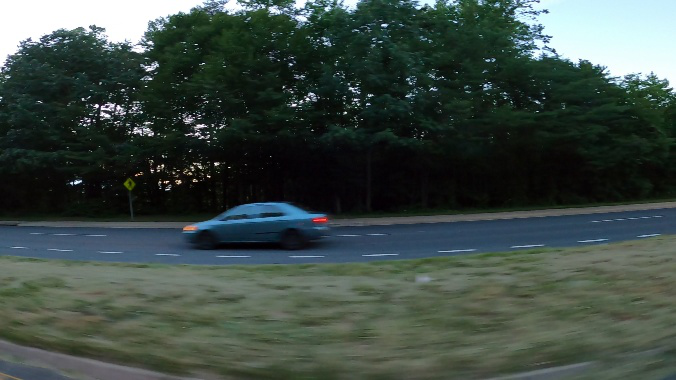

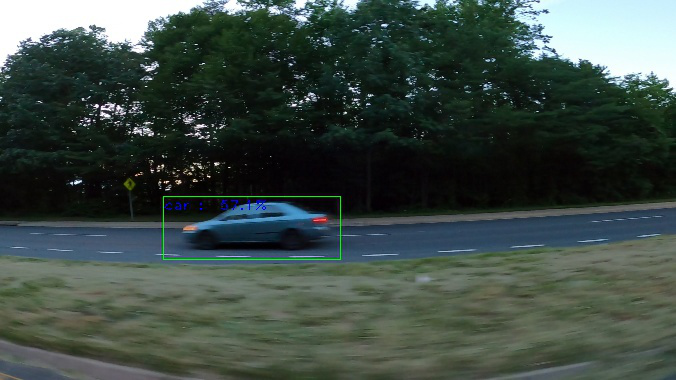

In [7]:
test_image_path = PATH+'test/images/vid_5_26580.jpg'
detect_image_path = PATH+'test/predicted/vid_5_26580.jpg'
display.display(Image.open(test_image_path))
display.display(Image.open(detect_image_path))